In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import math

In [2]:
from transformers import AutoTokenizer, AutoFeatureExtractor, AutoModel
import torchvision.transforms as T
import torch
from torch import nn

In [3]:
test_df = pd.read_pickle("data/CLEVR_v1.0/test-data.pkl")

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print("Using: ", device)

Using:  cpu


In [5]:
text_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
text_encoder = AutoModel.from_pretrained("bert-base-uncased")
for p in text_encoder.parameters():
    p.requires_grad = False

image_processor = AutoFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
image_encoder = AutoModel.from_pretrained("google/vit-base-patch16-224-in21k")
for p in image_encoder.parameters():
    p.requires_grad = False

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
if torch.cuda.device_count() > 1:
    print("Available GPU's: ", torch.cuda.device_count())
    image_encoder = nn.DataParallel(image_encoder)
    text_encoder = nn.DataParallel(text_encoder)


image_encoder.to(device)
text_encoder.to(device)

In [8]:
class NewQAEarlyFusionNetwork(nn.Module):

    def __init__(self, hyperparms=None):

        super(NewQAEarlyFusionNetwork, self).__init__()        
        self.dropout = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 256)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.classifier = nn.Linear(256, 28) 
        W = torch.Tensor(768, 768)
        self.W = nn.Parameter(W)
        self.relu_f = nn.ReLU()
        # initialize weight matrices
        nn.init.kaiming_uniform_(self.W, a=math.sqrt(5))
        
    def forward(self, image_emb, text_emb):

        x_img = image_emb   
        
        x_text = text_emb

        Xvt = x_img * x_text
        Xvt = self.relu_f(torch.mm(Xvt, self.W.t()))


        Xvt = self.fc1(Xvt)
        Xvt = self.bn1(Xvt)
        Xvt = self.relu_f(Xvt)
        Xvt = self.fc2(Xvt)
        Xvt = self.bn2(Xvt)
        Xvt = self.relu_f(Xvt)
        Xvt = self.dropout(Xvt)
        Xvt = self.classifier(Xvt)

        return Xvt

In [10]:
answer_code_key = {'yes': 0,
 '2': 1,
 'no': 2,
 'rubber': 3,
 'large': 4,
 '0': 5,
 'sphere': 6,
 'gray': 7,
 'cube': 8,
 'blue': 9,
 'brown': 10,
 '1': 11,
 'yellow': 12,
 'purple': 13,
 'cylinder': 14,
 'small': 15,
 'green': 16,
 'metal': 17,
 '3': 18,
 '4': 19,
 'cyan': 20,
 '6': 21,
 'red': 22,
 '5': 23,
 '8': 24,
 '7': 25,
 '9': 26,
 '10': 27}

Image Name:  CLEVR_val_000007.png
Question Index:  148


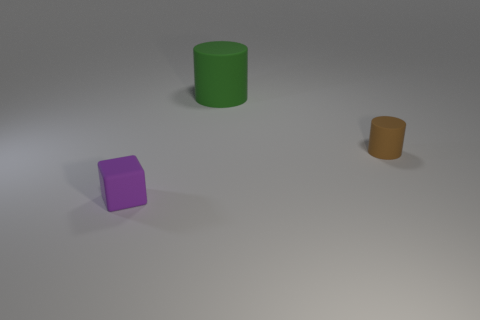

Question:  There is a brown matte object that is the same size as the purple cube; what is its shape?
Ground Truth:  CYLINDER


tensor(14)
ANSWER:  CYLINDER

 ******************************
Top 3 Probabilities:
cylinder ~ 3.184803009033203
cube ~ 2.8640453815460205
sphere ~ 2.0868451595306396


In [43]:
from PIL import Image
import random
from collections import OrderedDict


query_df = test_df.iloc[:200]

idx = random.randint(0, len(query_df))

print("Image Name: ", query_df['image_filename'][idx])

print("Question Index: ", idx)

image_to_display = query_df['image'][idx]
question = query_df['question'][idx]
image = query_df['resized_image'][idx]
label = query_df['answer_code'][idx]

image_inputs = image_processor(image, return_tensors="pt")
image_inputs = {k:v.to(device) for k,v in image_inputs.items()}
image_outputs = image_encoder(**image_inputs)
image_embedding = image_outputs.pooler_output
image_embedding = image_embedding.view(-1)
image_embedding = image_embedding.detach()

from IPython.display import Image
display(image_to_display)

print("Question: ", question)
print("Ground Truth: ", list(answer_code_key.keys())[list(answer_code_key.values()).index(label)].upper())

text_inputs = text_tokenizer(question, return_tensors="pt")
text_inputs = {k:v.to(device) for k,v in text_inputs.items()}
text_outputs = text_encoder(**text_inputs)
text_embedding = text_outputs.last_hidden_state[:,0,:]
text_embedding = text_embedding.view(-1)
text_embedding = text_embedding.detach()

encoding={}
encoding["image_emb"] = image_embedding
encoding["text_emb"] = text_embedding
encoding["label"] = torch.tensor(label)

batch = tuple(b.to(device) for b in encoding.values())
inputs = {'image_emb':  batch[0], 'text_emb': batch[1]} 
labels =  batch[2]

inputs['image_emb'] = inputs['image_emb'].view(1, -1)
inputs['text_emb'] = inputs['text_emb'].view(1, -1)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model_path = "models/epoch_5.model"
p_model = NewQAEarlyFusionNetwork()

check = torch.load(model_path, map_location=torch.device('cpu'))

new_state_dict = OrderedDict()

for k,v in check.items():
    k = k.replace('module.', '')
    new_state_dict[k] = v

p_model.load_state_dict(new_state_dict)
p_model.to(device)
p_model.eval()

with torch.no_grad():
    outputs = p_model(**inputs)

print("\n")
print(torch.argmax(outputs))
print("ANSWER: ", list(answer_code_key.keys())[list(answer_code_key.values()).index(torch.argmax(outputs).item())].upper())

print( "\n", "*" * 30)
print("Top 3 Probabilities:")
for arg, prob in zip(torch.argsort(outputs, descending=True).tolist()[0][:3], torch.sort(outputs, descending=True).values.tolist()[0][:3]):
    print(list(answer_code_key.keys())[list(answer_code_key.values()).index(arg)], '~', prob)